# 1. Introduction

Briefly describe the recommendation task, the Neural Matrix Factorization approach,
and list the datasets: interactions_new, tracks, catalog_names.
-->
In this notebook, we implement a Neural Matrix Factorization (NeuMF) recommendation algorithm using PyTorch.  
We will work with three datasets:  
- **interactions_new**: user–track interaction logs  
- **tracks**: metadata about tracks (albums, artists, genres)  
- **catalog_names**: mapping of album/artist/genre names  

The goal is to build and evaluate a NeuMF model for implicit feedback.

# 2. Imports and Settings

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 3. Datasets loading

In [2]:
interactions = pd.read_parquet("interactions_new.parquet")
tracks = pd.read_parquet("tracks.parquet")
catalog = pd.read_parquet("catalog_names.parquet")

In [3]:
print(f"Interactions: {len(interactions)} rows")
print(f"Tracks:       {len(tracks)} rows")
print(f"Catalog:      {len(catalog)} rows")

Interactions: 200000 rows
Tracks:       1000000 rows
Catalog:      1812471 rows


In [4]:
interactions.tail()

,user_id,track_id,track_seq,started_at
9,1147,60164742,10,2022-12-10
10,1147,60441330,11,2022-12-13
11,1147,60715380,12,2022-12-19
12,1147,61693507,13,2022-12-21
13,1147,61835292,14,2022-12-21


In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
catalog.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [7]:
print("\nMissing values per column in interactions_new:")
print(interactions.isnull().sum())
print("\nMissing values per column in tracks:")
print(tracks.isnull().sum())
print("\nMissing values per column in catalog_names:")
print(catalog.isnull().sum())


Missing values per column in interactions_new:
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Missing values per column in tracks:
track_id    0
albums      0
artists     0
genres      0
dtype: int64

Missing values per column in catalog_names:
id      0
type    0
name    0
dtype: int64


# 4. Data manipualtions

In [8]:
# 2) Map raw IDs to contiguous indices
unique_users = interactions['user_id'].unique()
unique_items = interactions['track_id'].unique()
user2idx = {u: i for i, u in enumerate(unique_users)}
item2idx = {i: j for j, i in enumerate(unique_items)}

interactions['user_idx'] = interactions['user_id'].map(user2idx)
interactions['item_idx'] = interactions['track_id'].map(item2idx)

In [9]:
# 3) Ensure datetime sorting
interactions['started_at'] = pd.to_datetime(interactions['started_at'])
interactions = interactions.sort_values(['user_idx', 'started_at'])

In [10]:
# 4) Split train / validation: last interaction per user → val
is_last = ~interactions.duplicated(subset=['user_idx'], keep='last')
val_df   = interactions[ is_last].reset_index(drop=True)
train_df = interactions[~is_last].reset_index(drop=True)
print(f"Train interactions: {len(train_df)}, Validation interactions: {len(val_df)}")

Train interactions: 198855, Validation interactions: 1145


# 5. Negative sampling on train set

In [11]:

def negative_sampling(df, n_items, neg_rate=4, seed=42):
    rng = np.random.RandomState(seed)
    user_pos = df.groupby('user_idx')['item_idx'].agg(set).to_dict()
    users, items, labels = [], [], []
    for u, pos in user_pos.items():
        # positives
        for i in pos:
            users.append(u); items.append(i); labels.append(1)
        # negatives
        n_neg = len(pos) * neg_rate
        negs = set()
        while len(negs) < n_neg:
            cand = rng.randint(0, n_items, size=n_neg - len(negs))
            negs.update(set(cand) - pos)
        for i in negs:
            users.append(u); items.append(i); labels.append(0)
    return pd.DataFrame({'user_idx': users, 'item_idx': items, 'label': labels})

num_users = len(user2idx)
num_items = len(item2idx)
train_samples = negative_sampling(train_df, num_items, neg_rate=4)

# 6. Dataset & DataLoader

In [12]:
class InteractionDataset(Dataset):
    def __init__(self, samples_df):
        self.users = samples_df['user_idx'].values.astype(np.int64)
        self.items = samples_df['item_idx'].values.astype(np.int64)
        self.labels = samples_df['label'].values.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'item': self.items[idx],
            'label': self.labels[idx]
        }

batch_size = 1024
train_ds = InteractionDataset(train_samples)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,
                          pin_memory=torch.cuda.is_available())

# 7. Final NMF model

In [13]:
class NeuralMFEnhanced(nn.Module):
    def __init__(self, n_users, n_items, emb_size=64, layers=[128,64,32,16], dropout=0.3):
        super().__init__()
        # GMF embeddings + biases
        self.u_gmf = nn.Embedding(n_users, emb_size)
        self.i_gmf = nn.Embedding(n_items, emb_size)
        self.u_bias = nn.Embedding(n_users, 1)
        self.i_bias = nn.Embedding(n_items, 1)
        # MLP embeddings
        self.u_mlp = nn.Embedding(n_users, emb_size)
        self.i_mlp = nn.Embedding(n_items, emb_size)
        
        # build deep MLP with BatchNorm and residuals
        mlp_modules = []
        input_dim = emb_size * 2
        for h in layers:
            mlp_modules += [
                nn.Linear(input_dim, h, bias=False),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            input_dim = h
        self.mlp = nn.Sequential(*mlp_modules)
        
        # final prediction layer
        self.predict = nn.Linear(emb_size + layers[-1], 1)
        
        # initialization
        for emb in [self.u_gmf, self.i_gmf, self.u_mlp, self.i_mlp]:
            nn.init.normal_(emb.weight, 0, 0.01)
        nn.init.zeros_(self.u_bias.weight)
        nn.init.zeros_(self.i_bias.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, users, items):
        # GMF
        gmf_out = self.u_gmf(users) * self.i_gmf(items)
        # MLP
        x = torch.cat([self.u_mlp(users), self.i_mlp(items)], dim=1)
        mlp_out = self.mlp(x)
        # combining
        feat = torch.cat([gmf_out, mlp_out], dim=1)
        score = self.predict(feat).squeeze(1)
        # biases
        score = score + self.u_bias(users).squeeze(1) + self.i_bias(items).squeeze(1)
        return score

# 8. Inizialization and trainig

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralMFEnhanced(num_users, num_items).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [15]:
num_epochs = 30
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        users = batch['user'].to(device)
        items = batch['item'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(users, items)       # forward pass
        loss = criterion(logits, labels)   # BCE loss
        loss.backward()                    # backprop
        optimizer.step()                   # update weights
        
        total_loss += loss.item() * users.size(0)
    
    avg_loss = total_loss / len(train_ds)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")



Epoch 1/30, Loss: 0.5006
Epoch 2/30, Loss: 0.4536
Epoch 3/30, Loss: 0.4321
Epoch 4/30, Loss: 0.3888
Epoch 5/30, Loss: 0.3267
Epoch 6/30, Loss: 0.2734
Epoch 7/30, Loss: 0.2334
Epoch 8/30, Loss: 0.2040
Epoch 9/30, Loss: 0.1829
Epoch 10/30, Loss: 0.1659
Epoch 11/30, Loss: 0.1541
Epoch 12/30, Loss: 0.1455
Epoch 13/30, Loss: 0.1366
Epoch 14/30, Loss: 0.1308
Epoch 15/30, Loss: 0.1259
Epoch 16/30, Loss: 0.1213
Epoch 17/30, Loss: 0.1171
Epoch 18/30, Loss: 0.1136
Epoch 19/30, Loss: 0.1106
Epoch 20/30, Loss: 0.1085
Epoch 21/30, Loss: 0.1049
Epoch 22/30, Loss: 0.1044
Epoch 23/30, Loss: 0.1026
Epoch 24/30, Loss: 0.1008
Epoch 25/30, Loss: 0.0981
Epoch 26/30, Loss: 0.0965
Epoch 27/30, Loss: 0.0963
Epoch 28/30, Loss: 0.0944
Epoch 29/30, Loss: 0.0925
Epoch 30/30, Loss: 0.0925


# 9. Visualize training loss

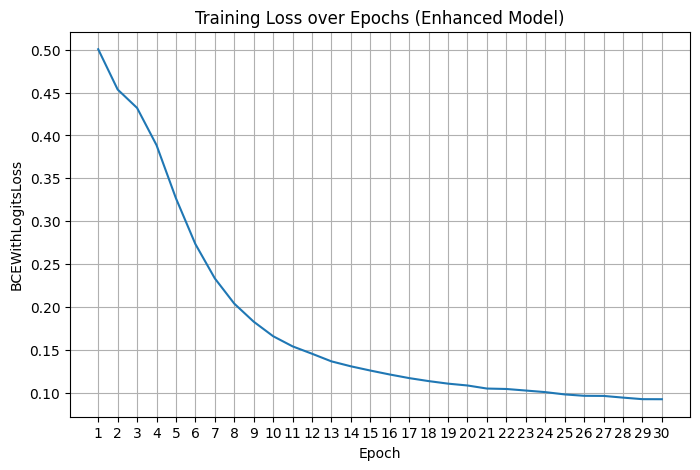

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history)
plt.title('Training Loss over Epochs (Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.xticks(range(1, num_epochs + 1))
plt.grid(True)
plt.show()

# 10. Evaluation Metrics

precision@K, recall@K, MAP@K, F1@K and NDCG@K.

In [17]:
def recall_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device='cpu'):
    """
    Compute Recall@k over a reduced candidate set:
      1) take top-N popular items from train_df
      2) for each user in val_df score only these candidates (+true item if missing)
      3) compute Recall@k
    """
    popular = train_df['item_idx'].value_counts().head(candidates_count).index.tolist()
    popular_set = set(popular)
    
    model.eval()
    hits = 0
    n_users = len(val_df)
    
    for _, row in val_df.iterrows():
        u = row['user_idx']
        true_i = row['item_idx']
        
        if true_i in popular_set:
            cands = popular
        else:
            cands = popular[:-1] + [true_i]
        
        users = torch.full((len(cands),), u, dtype=torch.long, device=device)
        items = torch.tensor(cands, dtype=torch.long, device=device)
        with torch.no_grad():
            scores = model(users, items)
        
        topk_idx = torch.topk(scores, k).indices.cpu().numpy()
        topk_items = [cands[i] for i in topk_idx]
        if true_i in topk_items:
            hits += 1
    
    recall = hits / n_users
    print(f"Recall@{k} over {candidates_count} candidates: {recall:.4f} ({hits}/{n_users})")
    return recall



def precision_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device='cpu'):
    popular = train_df['item_idx'].value_counts().head(candidates_count).index.tolist()
    popular_set = set(popular)

    model.eval()
    prec_sum = 0.0
    n_users = len(val_df)

    for _, row in val_df.iterrows():
        u, true_i = row['user_idx'], row['item_idx']
        cands = popular if true_i in popular_set else popular[:-1] + [true_i]

        users = torch.full((len(cands),), u, dtype=torch.long, device=device)
        items = torch.tensor(cands, dtype=torch.long, device=device)
        with torch.no_grad():
            scores = model(users, items)

        topk = torch.topk(scores, k).indices.cpu().numpy()
        hit = 1 if true_i in [cands[i] for i in topk] else 0
        prec_sum += hit / k

    return prec_sum / n_users


def mrr_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device='cpu'):
    popular = train_df['item_idx'].value_counts().head(candidates_count).index.tolist()
    popular_set = set(popular)

    model.eval()
    rr_sum = 0.0
    n_users = len(val_df)

    for _, row in val_df.iterrows():
        u, true_i = row['user_idx'], row['item_idx']
        cands = popular if true_i in popular_set else popular[:-1] + [true_i]

        users = torch.full((len(cands),), u, dtype=torch.long, device=device)
        items = torch.tensor(cands, dtype=torch.long, device=device)
        with torch.no_grad():
            scores = model(users, items)

        ranks = torch.argsort(scores, descending=True).cpu().numpy()
        topk = ranks[:k]
        pos = np.where(topk == cands.index(true_i))[0]
        if pos.size > 0:
            rr_sum += 1.0 / (pos[0] + 1)

    return rr_sum / n_users


def ndcg_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device='cpu'):
    popular = train_df['item_idx'].value_counts().head(candidates_count).index.tolist()
    popular_set = set(popular)

    model.eval()
    ndcg_sum = 0.0
    n_users = len(val_df)

    for _, row in val_df.iterrows():
        u, true_i = row['user_idx'], row['item_idx']
        cands = popular if true_i in popular_set else popular[:-1] + [true_i]

        users = torch.full((len(cands),), u, dtype=torch.long, device=device)
        items = torch.tensor(cands, dtype=torch.long, device=device)
        with torch.no_grad():
            scores = model(users, items)

        topk = torch.topk(scores, k).indices.cpu().numpy()
        # если есть
        if true_i in [cands[i] for i in topk]:
            rank = np.where(topk == cands.index(true_i))[0][0] + 1
            ndcg_sum += 1.0 / np.log2(rank + 1)

    return ndcg_sum / n_users


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

recall_cand   = recall_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device=device)
precision_cand= precision_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device=device)
mrr_cand      = mrr_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device=device)
ndcg_cand     = ndcg_at_k_candidates(model, val_df, train_df, k=10, candidates_count=5000, device=device)

print(f"Recall@10 (5000 cands):    {recall_cand:.4f}")
print(f"Precision@10 (5000 cands): {precision_cand:.4f}")
print(f"MRR@10 (5000 cands):       {mrr_cand:.4f}")
print(f"NDCG@10 (5000 cands):      {ndcg_cand:.4f}")


Recall@10 over 5000 candidates: 0.0035 (4/1145)
Recall@10 (5000 cands):    0.0035
Precision@10 (5000 cands): 0.0003
MRR@10 (5000 cands):       0.0005
NDCG@10 (5000 cands):      0.0012


# 11. Example for user

In [19]:
# keep only track names
track_names = catalog[catalog['type'] == 'track'].set_index('id')['name'].to_dict()

# reverse mapping from internal idx -> original track_id
idx2track = {v: k for k, v in item2idx.items()}

def recommend_top10(model, user_id, user2idx, idx2track, track_names, num_items, device='cpu'):
    """
    Return top-10 track names for a given user_id.
    """
    model.eval()
    u_idx = user2idx.get(user_id, None)
    if u_idx is None:
        raise ValueError(f"Unknown user_id {user_id}")
    # prepare tensor: repeat user index num_items times
    users = torch.full((num_items,), u_idx, dtype=torch.long, device=device)
    items = torch.arange(num_items, dtype=torch.long, device=device)
    with torch.no_grad():
        scores = model(users, items)
    # get top-10 item indices
    topk = torch.topk(scores, 10).indices.cpu().numpy()
    # map back to track_ids and names
    recommendations = []
    for rank, idx in enumerate(topk, start=1):
        track_id = idx2track[idx]
        name = track_names.get(track_id, "Unknown")
        recommendations.append((rank, track_id, name))
    return recommendations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

user_id = 123   
top10 = recommend_top10(
    model, user_id,
    user2idx, idx2track, track_names,
    num_items, device=device
)

print("Top-10 recommendations for user", user_id)
for rank, track_id, name in top10:
    print(f"{rank:2d}. [{track_id}] {name}")

Top-10 recommendations for user 123
 1. [178529] Numb
 2. [2758009] The Show Must Go On
 3. [6705392] Seven Nation Army
 4. [48951] It's My Life
 5. [560473] Полковнику никто не пишет
 6. [17352611] Chandelier
 7. [628970] I Hate Everything About You
 8. [14690772] Dark Horse
 9. [82036283] Seven Nation Army
10. [60292250] Blinding Lights



# 12. Save the final model

In [20]:
torch.save(model.state_dict(), "NMF.pt")
print("Model saved to NMF.pt")

Model saved to NMF.pt
